# Lesson 5 - Facial Similarity Search

### Import the required packages

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from deepface import DeepFace
from pinecone import Pinecone, ServerlessSpec
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import contextlib
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import time
from tqdm import tqdm


2024-04-08 06:13:06.733539: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-08 06:13:06.804772: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-08 06:13:07.867380: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
from DLAIUtils import Utils

In [4]:
# Get API key
utils = Utils()

PINECONE_API_KEY = utils.get_pinecone_api_key()

### Load the Dataset

**Note:** To access the dataset outside of this course, just copy the following two lines of code and run it (remember to uncomment them first before executing):

In [5]:
!mkdir -p ./data && wget -q --show-progress -O ./data/family_photos.zip "https://www.dropbox.com/scl/fi/yg0f2ynbzzd2q4nsweti5/family_photos.zip?rlkey=00oeuiii3jgapz2b1bfj0vzys&dl=0"

!unzip -q ./data/family_photos.zip -d ./data/

./data/family_photo 100%[===================>] 774.04K  2.79MB/s    in 0.3s    


Utility function to display image

In [6]:
def show_img(f):
    img = plt.imread(fname=f)
    plt.figure(figsize=(4,3))
    plt.imshow(img)


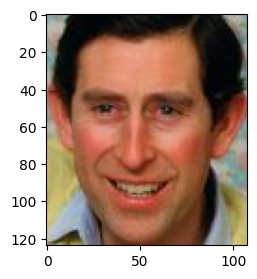

In [7]:
show_img('./data/family/dad/P06260_face5.jpg')

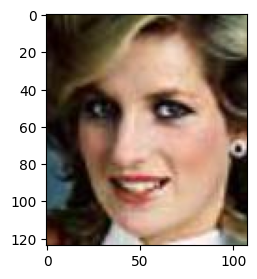

In [8]:
show_img('./data/family/mom/P04407_face2.jpg')

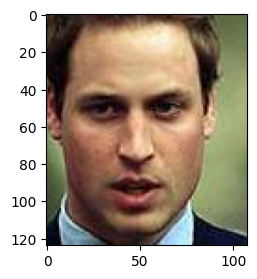

In [9]:
show_img('./data/family/child/P04414_face1.jpg')

### Setup Pinecone

In [10]:
pinecone = Pinecone(api_key=PINECONE_API_KEY)
INDEX_NAME = utils.create_dlai_index_name(index_name="dl-ai")
MODEL = "Facenet"


### Create Embeddings Using DeepFace

In [12]:
def generate_vectors():
    VECTOR_FILE = "./output/vectors.vec"

    with contextlib.suppress(NotADirectoryError):
        os.makedirs(os.path.dirname(VECTOR_FILE), exist_ok=True)

    with contextlib.suppress(FileNotFoundError):
        os.remove(VECTOR_FILE)
    
    with open(VECTOR_FILE, mode="w") as f:
        for person in ["mom", "dad", "child"]:
            files = glob.glob(f"./data/family/{person}/*")

            for file in tqdm(files):
                try:
                    embedding = DeepFace.represent(img_path=file, model_name=MODEL, enforce_detection=False)[0]["embedding"]
                    f.write(f"{person}:{os.path.basename(file)}:{embedding}\n")
                except (ValueError, UnboundLocalError, AttributeError) as e:
                    print(e)

In [13]:
generate_vectors()

  0%|          | 0/78 [00:00<?, ?it/s]2024-04-08 23:02:49.213603: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-08 23:02:49.223986: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


24-04-08 23:02:51 - facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /home/kaushik/.deepface/weights/facenet_weights.h5
100%|██████████| 92.2M/92.2M [00:05<00:00, 18.0MB/s]
100%|██████████| 93/93 [00:26<00:00,  3.54it/s]


Take a peek into the first few lines of vectors.vec

In [15]:
!head -10 ./output/vectors.vec

mom:P11928_face0.jpg:[0.12162064015865326, -0.3002133071422577, -0.5596491694450378, -2.248584747314453, -1.6901575326919556, -0.8795416355133057, -1.4762532711029053, 1.7611665725708008, -0.4491161108016968, 0.9927939176559448, 0.3604264557361603, -0.5260197520256042, -1.090276837348938, -0.40222591161727905, 0.9754151105880737, -0.5026860237121582, 1.8052252531051636, -0.4938303232192993, 0.8558483123779297, -1.66473388671875, -0.4446808993816376, -2.0353870391845703, 0.21975380182266235, 1.950177788734436, 1.005188226699829, 0.19376873970031738, 0.4372574985027313, -0.4840546250343323, 0.4775148034095764, 0.21455706655979156, 0.7791616916656494, -1.4370849132537842, 1.270476222038269, 0.42632943391799927, 0.3966073989868164, -0.15562380850315094, 1.7687323093414307, 2.411416530609131, -0.6529209613800049, -0.5921344757080078, -1.4828609228134155, -0.06497868150472641, 0.2375156581401825, 0.08121564984321594, -0.7050446271896362, 0.13616029918193817, -0.003721917048096657, -0.7725841

### Plot the Data of Images

In [16]:
def gen_tse_df(person, perplexity):
    vectors = []
    with open("./output/vectors.vec", mode="r") as f:
        for line in f:
            p, orig_img, v = line.split(":")
            if person == p:
                vectors.append(eval(v))
    
    pca = PCA(n_components=8)
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=1000, metric="euclidean",
                 verbose=0, random_state=0, learning_rate=75)
    
    print(f"Transform {len(vectors)} vectors")
    pca_transform = pca.fit_transform(vectors)
    embeddings2d = tsne.fit_transform(pca_transform)

    df = pd.DataFrame(data={"x": embeddings2d[:, 0], "y": embeddings2d[:, 1]})

    return df

In [17]:
def plot_tsne(perplexity, model):
    (_, ax) = plt.subplots(figsize=(8,5))
    plt.grid(color='#EAEAEB', linewidth=0.5)
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['left'].set_color('#2B2F30')
    ax.spines['bottom'].set_color('#2B2F30')
    colormap = {'dad':'#ee8933', 'child':'#4fad5b', 'mom':'#4c93db'}

    for person in colormap:
        embeddings_df = gen_tse_df(person=person, perplexity=perplexity)
        ax.scatter(embeddings_df.x, embeddings_df.y, alpha=0.5, label=person, color=colormap[person])
    
    plt.title(f'Scatter plot of faces using {model}', fontsize=16, fontweight='bold', pad=20)
    plt.suptitle(f't-SNE [perplexity={perplexity}]', y=0.92, fontsize=13)
    plt.legend(loc='best', frameon=True)
    plt.show()


Transform 70 vectors
Transform 93 vectors
Transform 78 vectors


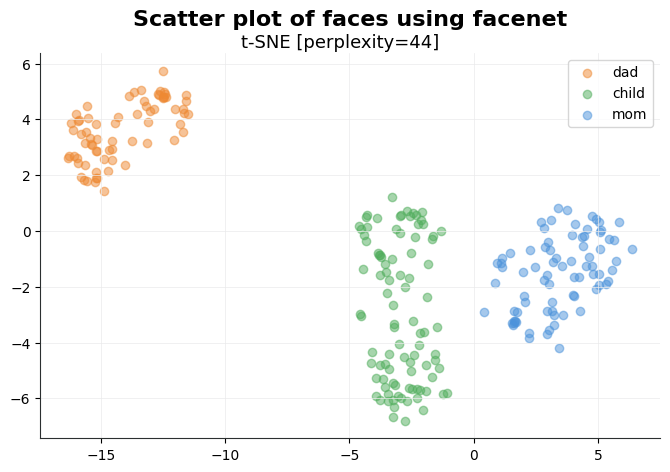

In [18]:
plot_tsne(perplexity=44, model="facenet")

### Store the Embeddings in Pinecone

In [19]:
if INDEX_NAME in [index.name for index in pinecone.list_indexes()]:
    pinecone.delete_index(name=INDEX_NAME)

pinecone.create_index(
    name=INDEX_NAME,
    dimension=128,
    spec=ServerlessSpec(cloud="aws", region="us-west-2"),
    metric="cosine"
)

index = pinecone.Index(name=INDEX_NAME)

In [33]:
with open("./output/vectors.vec", mode="r") as f:
        for line in tqdm(f):
           person, file, vec = line.split(":")
           print(f"{file}: {type(eval(vec))}: {all([isinstance(x, float) for x in eval(vec)])}: {eval(vec)}") 

241it [00:00, 1480.45it/s]

P11928_face0.jpg: <class 'list'>: True: [0.12162064015865326, -0.3002133071422577, -0.5596491694450378, -2.248584747314453, -1.6901575326919556, -0.8795416355133057, -1.4762532711029053, 1.7611665725708008, -0.4491161108016968, 0.9927939176559448, 0.3604264557361603, -0.5260197520256042, -1.090276837348938, -0.40222591161727905, 0.9754151105880737, -0.5026860237121582, 1.8052252531051636, -0.4938303232192993, 0.8558483123779297, -1.66473388671875, -0.4446808993816376, -2.0353870391845703, 0.21975380182266235, 1.950177788734436, 1.005188226699829, 0.19376873970031738, 0.4372574985027313, -0.4840546250343323, 0.4775148034095764, 0.21455706655979156, 0.7791616916656494, -1.4370849132537842, 1.270476222038269, 0.42632943391799927, 0.3966073989868164, -0.15562380850315094, 1.7687323093414307, 2.411416530609131, -0.6529209613800049, -0.5921344757080078, -1.4828609228134155, -0.06497868150472641, 0.2375156581401825, 0.08121564984321594, -0.7050446271896362, 0.13616029918193817, -0.00372191704

In [34]:
def store_vectors():
    with open("./output/vectors.vec", mode="r") as f:
        for line in tqdm(f):
            person, file, vec = line.split(":")
            index.upsert([(f"{person}-{file}", eval(vec), {"person": person, "file": file})])

In [35]:
store_vectors()

241it [01:16,  3.17it/s]


In [36]:
index.describe_index_stats()

{'dimension': 128,
 'index_fullness': 0.0,
 'namespaces': {'': {'vector_count': 241}},
 'total_vector_count': 241}

### Calculate the Similarity Scores

In [37]:
def test(vec_groups, parent, child, K=10, SAMPLE_SIZE=10):
    index = pinecone.Index(name=INDEX_NAME)
    parent_vecs = vec_groups[parent]

    sum = 0
    for i in tqdm(range(0, SAMPLE_SIZE)):
        query_response = index.query(
            vector=parent_vecs[i],
            top_k=K,
            filter={"person": {"$eq": child}}
        )

        for row in query_response["matches"]:
            sum += row["score"]
        
    print(f"\n\n{parent}: AVG: {sum/(K*SAMPLE_SIZE)}")

In [38]:
def compute_scores():
    index = pinecone.Index(name=INDEX_NAME)
    vec_groups = {"dad": [], "mom": [], "child": []}

    with open("./output/vectors.vec", mode="r") as f:
        for line in tqdm(f):
            person, file, vec = line.split(":")
            vec_groups[person].append(eval(vec))
    
    print(f"DAD {'-' * 20}")
    test(vec_groups=vec_groups, parent="dad", child="child")
    print(f"MOM {'-' * 20}")
    test(vec_groups=vec_groups, parent="mom", child="child")

In [39]:
compute_scores()

241it [00:00, 4008.94it/s]


DAD --------------------


100%|██████████| 10/10 [00:05<00:00,  1.82it/s]




dad: AVG: 0.4042801591
MOM --------------------


100%|██████████| 10/10 [00:04<00:00,  2.45it/s]



mom: AVG: 0.33658581058


### Check the Matching Images

In [40]:
child_base = "./data/family/child/P06310_face1.jpg"

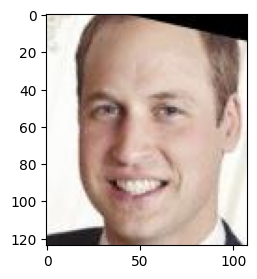

In [41]:
show_img(child_base)

Compute the embedding of child_base image

In [42]:
embedding = DeepFace.represent(img_path=child_base, model_name=MODEL)[0]["embedding"]
print(embedding)

[0.528397798538208, 1.286186933517456, -0.3561449348926544, -1.0126641988754272, 0.998286783695221, 0.6666196584701538, 0.5679239630699158, 1.6064081192016602, 0.14698481559753418, -0.530756413936615, 0.33921554684638977, -1.0853034257888794, -0.7407276630401611, -1.2022427320480347, -0.24404311180114746, -0.43662047386169434, -1.6220453977584839, -2.9247565269470215, -0.3545478880405426, -0.24917566776275635, 0.030635014176368713, -0.21422068774700165, -0.4420803189277649, -0.31803277134895325, -0.4128820598125458, -0.32468676567077637, 1.1288130283355713, 0.4614962041378021, -0.8908517956733704, 0.5013216137886047, -1.8914408683776855, -0.10036274790763855, -2.0040066242218018, -0.5636618137359619, 0.4059171676635742, -0.5800122022628784, -1.5189825296401978, -1.6227515935897827, 1.59950852394104, -0.30095812678337097, -0.9496637582778931, -1.9736131429672241, -2.546037197113037, -0.24491393566131592, 1.7347707748413086, -1.62643563747406, 1.3015128374099731, 0.9842944145202637, 0.85

Now find the closest given that we know dad is "most similar"

In [43]:
query_response = index.query(
    vector=embedding,
    top_k=3,
    filter={"person": {"$eq": "dad"}},
    include_metadata=True
)

In [44]:
print(query_response)

{'matches': [{'id': 'dad-P06396_face3.jpg',
              'metadata': {'file': 'P06396_face3.jpg', 'person': 'dad'},
              'score': 0.438954,
              'values': []},
             {'id': 'dad-P11886_face3.jpg',
              'metadata': {'file': 'P11886_face3.jpg', 'person': 'dad'},
              'score': 0.419916302,
              'values': []},
             {'id': 'dad-P04408_face0.jpg',
              'metadata': {'file': 'P04408_face0.jpg', 'person': 'dad'},
              'score': 0.407585829,
              'values': []}],
 'namespace': '',
 'usage': {'readUnits': 6}}


Display the matched dad images

In [45]:
# Best match
photo = query_response["matches"][0]["metadata"]["file"]

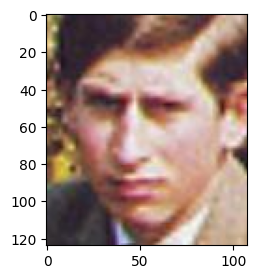

In [46]:
show_img(f"./data/family/dad/{photo}")

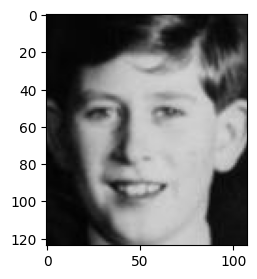

In [48]:
# 2nd Best match
photo = query_response["matches"][1]["metadata"]["file"]
show_img(f"./data/family/dad/{photo}")

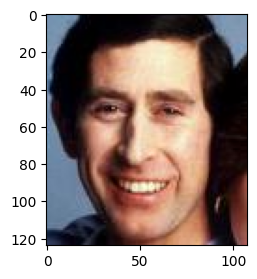

In [49]:
# 3rd Best match
photo = query_response["matches"][2]["metadata"]["file"]
show_img(f"./data/family/dad/{photo}")